In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import scipy
import sklearn
from datetime import datetime
import locale

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder

In [27]:
pd.set_option('display.max_rows', 10000)

In [4]:
noise_data = pd.read_csv("C:/Users/Axl Wynants/MDA-Georgia/Data/hourly_noisedata_2022.csv", header = 0, sep=',')
noise_data.head()

month  day  hour                       description      lamax       laeq
0      1    1     0      MP 03: Naamsestraat 62 Taste  60.322528  57.126833
1      1    1     0    MP 05: Calvariekapel KU Leuven  53.230972  49.987639
2      1    1     0  MP 06: Parkstraat 2 La Filosovia  53.666056  50.752000
3      1    1     0            MP 07: Naamsestraat 81  50.056861  47.440222
4      1    1     1      MP 03: Naamsestraat 62 Taste  53.033583  50.853806

In [5]:
noise_data = noise_data[noise_data["description"] == "MP 03: Naamsestraat 62 Taste"]
print(noise_data)
#Just location 3 for now

       month  day  hour                   description      lamax       laeq
0          1    1     0  MP 03: Naamsestraat 62 Taste  60.322528  57.126833
4          1    1     1  MP 03: Naamsestraat 62 Taste  53.033583  50.853806
8          1    1     2  MP 03: Naamsestraat 62 Taste  52.173702  50.049903
12         1    1     3  MP 03: Naamsestraat 62 Taste  50.821311  48.964907
16         1    1     4  MP 03: Naamsestraat 62 Taste  49.134851  47.285893
...      ...  ...   ...                           ...        ...        ...
55439     12   31    19  MP 03: Naamsestraat 62 Taste  55.340278  53.559333
55445     12   31    20  MP 03: Naamsestraat 62 Taste  53.803528  52.055583
55451     12   31    21  MP 03: Naamsestraat 62 Taste  52.387139  50.424556
55457     12   31    22  MP 03: Naamsestraat 62 Taste  53.031611  51.030861
55463     12   31    23  MP 03: Naamsestraat 62 Taste  59.199583  56.661017

[8759 rows x 6 columns]


In [7]:
noise_month = noise_data[noise_data["month"] == 3]  
noise_day = noise_month[noise_month["day"] == 27]
len(noise_day)

23

In [6]:
weather_data = pd.read_csv("C:/Users/Axl Wynants/MDA-Georgia/Data/hourly_weatherdata_2022.csv", header = 0, sep=',')
weather_data.head()

Month  Day  Hour  LC_RAININ  LC_DAILYRAIN  LC_WINDDIR  LC_WINDSPEED   
0      1    1     0   0.000003       0.00036  -18.197324      0.389565  \
1      1    1     1   0.000007       0.00000  -16.227891      0.222602   
2      1    1     2   0.000009       0.00000  -13.710884      0.217194   
3      1    1     3   0.000000       0.00000  -16.401361      0.178248   
4      1    1     4   0.000000       0.00000  -10.268707      0.237670   

   LC_TEMP_QCL3  
0     13.100358  
1     12.669197  
2     12.520271  
3     12.386194  
4     12.080706

In [7]:
noise_series = pd.Series(noise_data['laeq'])
temp_series = pd.Series(weather_data['LC_TEMP_QCL3'])
rain_series = pd.Series(weather_data['LC_RAININ'])
rain_cumul_series = pd.Series(weather_data['LC_DAILYRAIN'])
windspeed_series = pd.Series(weather_data['LC_WINDSPEED'])

In [35]:
len(noise_series)

8759

In [36]:
len(temp_series)

8760

In [37]:
len(rain_series)

8760

In [8]:
#Forward impute single observation in noise series on March 27 2AM
noise_series.loc[9430] = 50.700694
noise_series = noise_series.sort_index()
noise_series = noise_series.reset_index().drop('index', axis = 1)
print(noise_series)

           laeq
0     57.126833
1     50.853806
2     50.049903
3     48.964907
4     47.285893
...         ...
8755  53.559333
8756  52.055583
8757  50.424556
8758  51.030861
8759  56.661017

[8760 rows x 1 columns]


In [9]:
#Day of week one hot encoding. Go for 24 hours, skip 144. Year starts on a saturday
lst = [6, 7, 1, 2, 3, 4, 5]
lst_new = list(np.repeat(lst,24))
lst_newnew = lst_new * 53
day = np.array(lst_newnew[0:8760])

weekday = pd.get_dummies(day, prefix=['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri'])


In [37]:
#Get holidays
holiday_df = pd.read_csv("C:/Users/Axl Wynants/MDA-Georgia/Holidays.csv", header = 0, sep=',')
holiday_list = holiday_df['Date'].tolist()

locale.setlocale(locale.LC_TIME, 'nl_NL')

formatted_holidays = []
for date_str in holiday_list:
    date_obj = datetime.strptime(date_str, "%d %b")
    formatted_holidays.append(date_obj)

formatted_holidays = [date_obj.strftime("%m-%d") for date_obj in formatted_holidays]
prefix = '2022-'
formatted_holidays = [prefix + i for i in formatted_holidays]


start_date = '2022-01-01 00:00:00'
end_date = '2022-12-31 23:59:59'
index = pd.date_range(start=start_date, end=end_date, freq='H')
df = pd.DataFrame(index=index)

df['Holiday'] = 0

for holiday in formatted_holidays:
    df.loc[holiday, 'Holiday'] = 1

holiday = pd.Series(df['Holiday'])
holiday_series = holiday.reset_index(drop = True)
len(holiday_series)

8760

In [38]:
#Combine into a feature matrix
features = pd.concat([weekday, holiday_series, temp_series, rain_series, rain_cumul_series, windspeed_series], axis=1)
display(features)

['sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri']_1   
0                                                 False    \
1                                                 False     
2                                                 False     
3                                                 False     
4                                                 False     
5                                                 False     
6                                                 False     
7                                                 False     
8                                                 False     
9                                                 False     
10                                                False     
11                                                False     
12                                                False     
13                                                False     
14                                                False     
15                                                False     
16                                                False     
17                                                False     
18                                                False     
19                                                False     
20                                                False     
21                                                False     
22                                                False     
23                                                False     
24                                                False     
25                                                False     
26                                                False     
27                                                False     
28                                                False     
29                                                False     
30                                                False     
31                                                False     
32                                                False     
33                                                False     
34                                                False     
35                                                False     
36                                                False     
37                                                False     
38                                                False     
39                                                False     
40                                                False     
41                                                False     
42                                                False     
43                                                False     
44                                                False     
45                                                False     
46                                                False     
47                                                False     
48                                                 True     
49                                                 True     
50                                                 True     
51                                                 True     
52                                                 True     
53                                                 True     
54                                                 True     
55                                                 True     
56                                                 True     
57                                                 True     
58                                                 True     
59                                                 True     
60                                                 True     
61                                                 True     
62                                                 True     
63                                                 True     
64                                       

In [14]:
np.corrcoef(noise_series, temp_series)
#Positively correlated with temperature as expected

array([[1.        , 0.22365862],
       [0.22365862, 1.        ]])

In [15]:
np.corrcoef(noise_series, rain_series)
#Positively correlated with rain?

array([[1.        , 0.17214263],
       [0.17214263, 1.        ]])

In [16]:
np.corrcoef(noise_series, rain_cumul_series)

array([[1.        , 0.07950235],
       [0.07950235, 1.        ]])

In [17]:
np.corrcoef(noise_series, windspeed_series) 
#ofc more wind more noise

array([[1.        , 0.20323506],
       [0.20323506, 1.        ]])

In [127]:
#Lagged crosscorrelation with temp
crosscor = sm.tsa.stattools.ccf(temp_series, noise_series, adjusted=False)
print(crosscor[0:50])

[ 0.22365862  0.2142166   0.18724367  0.14290011  0.08436395  0.01643265
 -0.05418668 -0.12136306 -0.18019974 -0.22598216 -0.25540294 -0.26608084
 -0.25772045 -0.2319899  -0.19258968 -0.14379399 -0.09017662 -0.03540677
  0.01834559  0.06954472  0.1156653   0.15515311  0.18634794  0.20717762
  0.2146224   0.20541942  0.17815155  0.13357491  0.07503406  0.0072108
 -0.06373958 -0.13152592 -0.19092213 -0.23744135 -0.26756308 -0.27866947
 -0.27017309 -0.24418608 -0.20441847 -0.15518905 -0.10128307 -0.04654117
  0.00679964  0.05724626  0.10308905  0.14229216  0.17360959  0.1946576
  0.20228387  0.19351143]


In [128]:
#Lagged crosscorrelation with rain
crosscor = sm.tsa.stattools.ccf(rain_series, noise_series, adjusted=False)
print(crosscor[0:50])

[ 0.17214263  0.17982325  0.17603795  0.16421999  0.14329122  0.11909052
  0.09682295  0.07484539  0.05002924  0.02044498 -0.01157186 -0.04355385
 -0.07342476 -0.09890932 -0.1213651  -0.13337976 -0.12660959 -0.09745228
 -0.05530641 -0.01112555  0.03049002  0.06640684  0.09667412  0.11776471
  0.13137859  0.13642016  0.13184591  0.11946939  0.09952919  0.07778231
  0.05516712  0.03244995  0.00893798 -0.01580532 -0.04162226 -0.06694264
 -0.09051169 -0.11061532 -0.12661013 -0.13479366 -0.127126   -0.09900248
 -0.05700455 -0.01170359  0.03092194  0.06754651  0.09709388  0.11530865
  0.12625662  0.13087008]


In [39]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(features, noise_series,
    test_size=0.2)

#Convert target variables to 1D arrays
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [ ]:
#'sun': sun, 'mon': mon, 'tue': tue, 'wed': wed, 'tue': tue, 'fri': fri

In [46]:
#Random forest
model = RandomForestRegressor()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [47]:
#Random forest evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)


Mean Squared Error (MSE): 6.7978027670564165
Mean Absolute Error (MAE): 1.9063301152578376
R-squared Score (R2): 0.5280622798223575


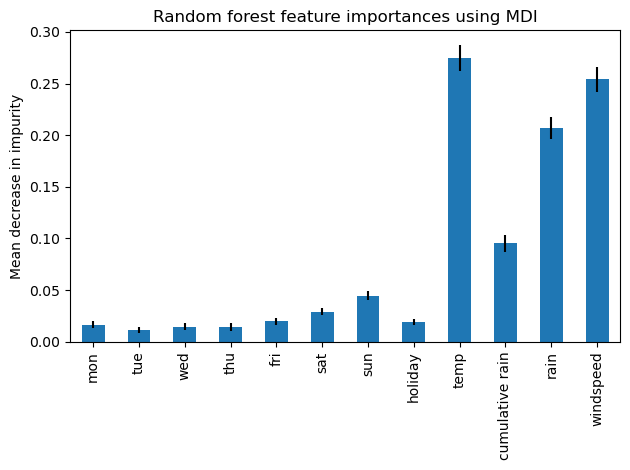

In [48]:
#Feature importance
importances = model.feature_importances_

forest_importances = pd.Series(importances, index=['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun', 'holiday', 'temp', 
                                                   'cumulative rain', 'rain', 'windspeed'])
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Random forest feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [25]:
#Try to improve the model with small grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 5, 10],       # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required to be at a leaf node
}

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


In [32]:
#Evaluate grid-search fitted rf
predictions1 = best_model.predict(X_test)

mse = mean_squared_error(y_test, predictions1)
mae = mean_absolute_error(y_test, predictions1)
r2 = r2_score(y_test, predictions1)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared Score (R2):", r2)
#Actually much better but need more computational power to do a proper search

Mean Squared Error (MSE): 8.89752812729372
Mean Absolute Error (MAE): 2.276941565491747
R-squared Score (R2): 0.3991628496671723
